Loading signals from: C:\Users\soltv\Documents\GitHub\newalgotrade\data\signals_nvda_lstm_hist.csv
Head:
                 Close  Pred_Close  pred_ret  signal
Date                                                
2024-06-14  131.830933   126.78307 -0.021447      -1
2024-06-17  130.931259   130.19957 -0.012375       0
2024-06-18  135.529541   131.39592  0.003549       0
2024-06-20  130.731323   132.94662 -0.019058       0
2024-06-21  126.522888   132.34123  0.012315       0
Dtypes:
Close         float64
Pred_Close    float64
pred_ret      float64
signal          int64
dtype: object
Final buy&hold multiple : 1.3568894745078286
Final strategy multiple: 0.9634034407897685

=== LSTM Strategy (NVDA) ===
Annualized return : 0.49%
Annualized vol    : 24.79%
Sharpe (rf=0)     : 0.02

=== Buy & Hold (NVDA) ===
Annualized return : 41.59%
Annualized vol    : 51.94%
Sharpe (rf=0)     : 0.80


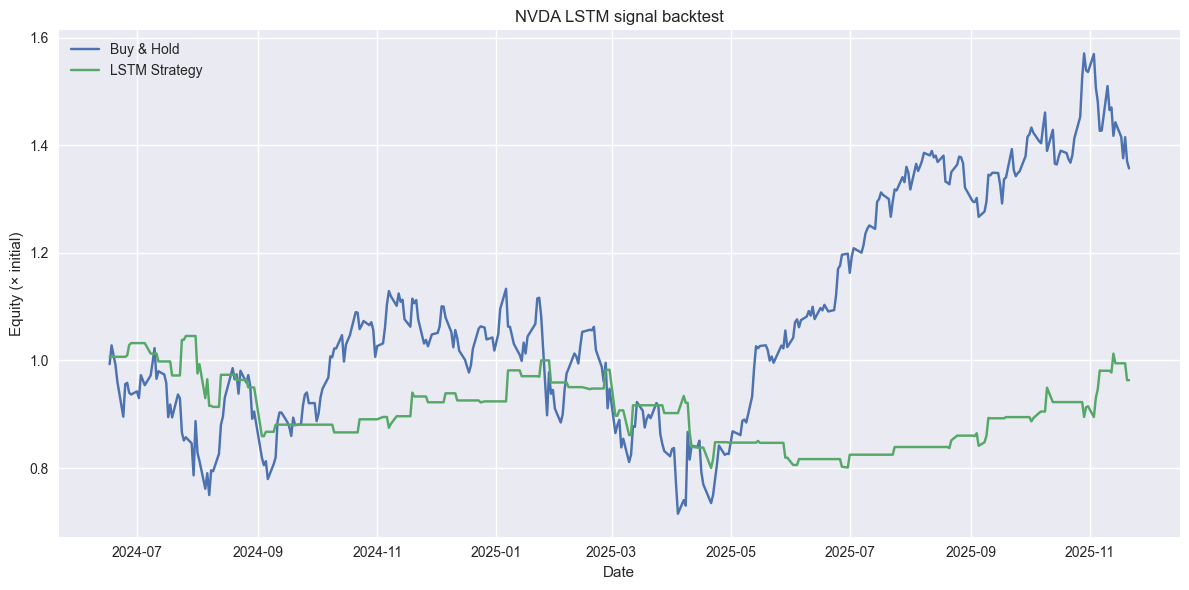

In [2]:
"""
Backtest LSTM-based signals for NVDA.

Expected input CSV: data/signals_nvda_lstm_hist.csv

Columns:
    Date    - date of bar (used as index)
    Close   - actual NVDA close on that date
    signal  - position decided at END of this date: -1 (short), 0 (flat), +1 (long)
"""

# ============================
# Imports
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("seaborn-v0_8")

# ============================
# 1. Load signals
# ============================

# This file is in NEWALGOTRADE root (or run notebook from there)
project_root = Path().resolve()
sig_path = project_root / "data" / "signals_nvda_lstm_hist.csv"

print("Loading signals from:", sig_path)
signals = pd.read_csv(sig_path, parse_dates=["Date"], index_col="Date")
signals = signals.sort_index()

print("Head:")
print(signals.head())
print("Dtypes:")
print(signals.dtypes)

# Ensure correct dtypes
signals["Close"] = signals["Close"].astype(float)
signals["signal"] = signals["signal"].astype(int)

bt = signals.copy()

# ============================
# 2. Compute daily returns
# ============================

# Asset daily return
bt["ret"] = bt["Close"].pct_change()

# Use yesterday's signal for today's return (avoid look-ahead bias)
bt["position"] = bt["signal"].shift(1).fillna(0)

# Strategy return
bt["strategy_ret"] = bt["position"] * bt["ret"]

# Drop initial NaNs
bt = bt.dropna(subset=["ret"])

# ============================
# 3. Cumulative performance
# ============================

bt["cum_asset"] = (1 + bt["ret"].fillna(0)).cumprod()
bt["cum_strategy"] = (1 + bt["strategy_ret"].fillna(0)).cumprod()

print("Final buy&hold multiple :", bt["cum_asset"].iloc[-1])
print("Final strategy multiple:", bt["cum_strategy"].iloc[-1])

# ============================
# 4. Performance metrics
# ============================

ann_factor = 252  # trading days per year

# Strategy stats
avg_daily_s = bt["strategy_ret"].mean()
std_daily_s = bt["strategy_ret"].std()

ann_return_s = (1 + avg_daily_s) ** ann_factor - 1
ann_vol_s    = std_daily_s * np.sqrt(ann_factor)
sharpe_s     = ann_return_s / ann_vol_s if ann_vol_s > 0 else np.nan

print("\n=== LSTM Strategy (NVDA) ===")
print(f"Annualized return : {ann_return_s:.2%}")
print(f"Annualized vol    : {ann_vol_s:.2%}")
print(f"Sharpe (rf=0)     : {sharpe_s:.2f}")

# Buy & hold stats
avg_daily_bh = bt["ret"].mean()
std_daily_bh = bt["ret"].std()

ann_return_bh = (1 + avg_daily_bh) ** ann_factor - 1
ann_vol_bh    = std_daily_bh * np.sqrt(ann_factor)
sharpe_bh     = ann_return_bh / ann_vol_bh if ann_vol_bh > 0 else np.nan

print("\n=== Buy & Hold (NVDA) ===")
print(f"Annualized return : {ann_return_bh:.2%}")
print(f"Annualized vol    : {ann_vol_bh:.2%}")
print(f"Sharpe (rf=0)     : {sharpe_bh:.2f}")

# ============================
# 5. Plot equity curves
# ============================

plt.figure(figsize=(12, 6))
plt.plot(bt.index, bt["cum_asset"], label="Buy & Hold")
plt.plot(bt.index, bt["cum_strategy"], label="LSTM Strategy")
plt.title("NVDA LSTM signal backtest")
plt.xlabel("Date")
plt.ylabel("Equity (× initial)")
plt.legend()
plt.tight_layout()
plt.show()